In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
from analysis.fid import compute_fid
import torch
import torchvision
import numpy as np
import scipy.stats
import scipy.cluster
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
import json

In [2]:
# Plotting defaults
font_list = font_manager.findSystemFonts(fontpaths=["/gstore/home/tsenga5/modules/fonts"])
for font in font_list:
    font_manager.fontManager.addfont(font)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "font.size": 13,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
branch_defs_dir = "/gstore/home/tsenga5/branched_diffusion/data/config/classes_branch_points/mnist/branch_point_discovery_variants/"
cache_dir = "/gstore/home/tsenga5/branched_diffusion/results/mnist_branch_variation/"

In [4]:
out_path = "/gstore/home/tsenga5/branched_diffusion/figures/branch_variation"

os.makedirs(out_path, exist_ok=True)

### Create the data loader

In [5]:
samples_per_digit = 100
dataset = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)

classes = torch.unique(dataset.targets).cpu().numpy()

In [6]:
num_trials = 10

### Visualize variation in branch definitions

In [7]:
def import_classes_branch_points(json_path):
    with open(json_path, "r") as f:
        d = json.load(f)
        return d["classes"], \
            [(tuple(trip[0]), trip[1], trip[2]) for trip in d["branches"]]

all_branch_defs = []
for i in range(num_trials):
    json_path = os.path.join(branch_defs_dir, "trial_%d.json" % i)
    all_branch_defs.append(import_classes_branch_points(json_path)[1])

In [8]:
def branch_defs_to_linkage_matrix(branch_defs, add_outgroup=True):
    """
    Converts a list of branch-definition triplets into a SciPy
    hierarchy linkage matrix.
    Returns a linkage matrix, and a dictionary mapping cluster ID
    in the linkage matrix to the actual class.
    If `add_outgroup` is True, then also add a dummy outgroup with
    class name "$".
    """
    classes = max(branch_defs, key=(lambda t: len(t[0])))[0]
    max_time = max(branch[2] for branch in branch_defs)
    
    if add_outgroup:
        epsilon = 1e-6
        branch_defs = branch_defs + [
            (("$",), 0, max_time),
            (classes + ("$",), max_time, max_time)
        ]
        classes = classes + ("$",)
    
    branch_defs = sorted(branch_defs, key=(lambda t: t[1]))

    linkage = []
    clusters = {}  # Map cluster ID to pair: (cluster elements, endpoint)
    cluster_id_to_leaf = {}  # Map cluster ID to actual leaf element

    for i, (elems, start, end) in enumerate(branch_defs):
        if i < len(classes):
            assert len(elems) == 1
            assert start == 0
            clusters[i] = (elems, end)
            cluster_id_to_leaf[i] = elems[0]
        elif i == len(branch_defs) - 1:
            assert len(elems) == len(classes)
            assert end == max_time
            assert len(clusters) == 2
            cluster_ids = list(clusters.keys())
            linkage.append([cluster_ids[0], cluster_ids[1], start, len(elems)])
        else:
            # Find the two clusters whose endpoint are this startpoint, and whose
            # elements add up to this cluster
            matches = [
                (cluster_id, tup) for cluster_id, tup in clusters.items()
                if tup[1] == start and set(tup[0]) < set(elems)
            ]
            assert len(matches) == 2 and set(matches[0][1][0] + matches[1][1][0]) == set(elems)
            linkage.append([matches[0][0], matches[1][0], start, len(elems)])
            clusters[i] = (elems, end)
            # Delete clusters that were just joined (makes subsequent searches faster)
            del clusters[matches[0][0]]
            del clusters[matches[1][0]]
            
    return linkage, cluster_id_to_leaf

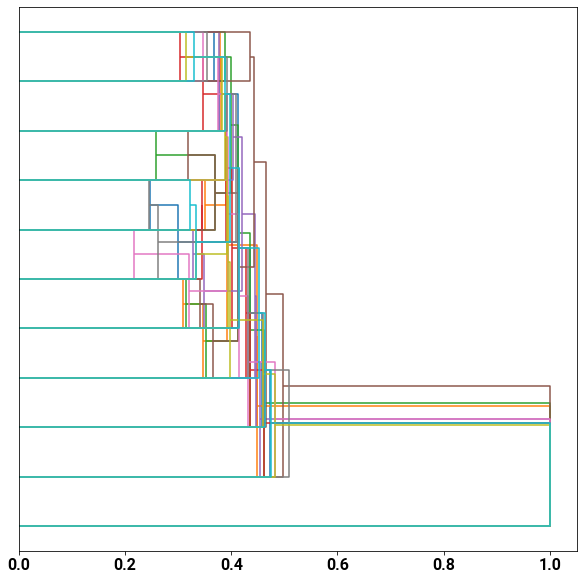

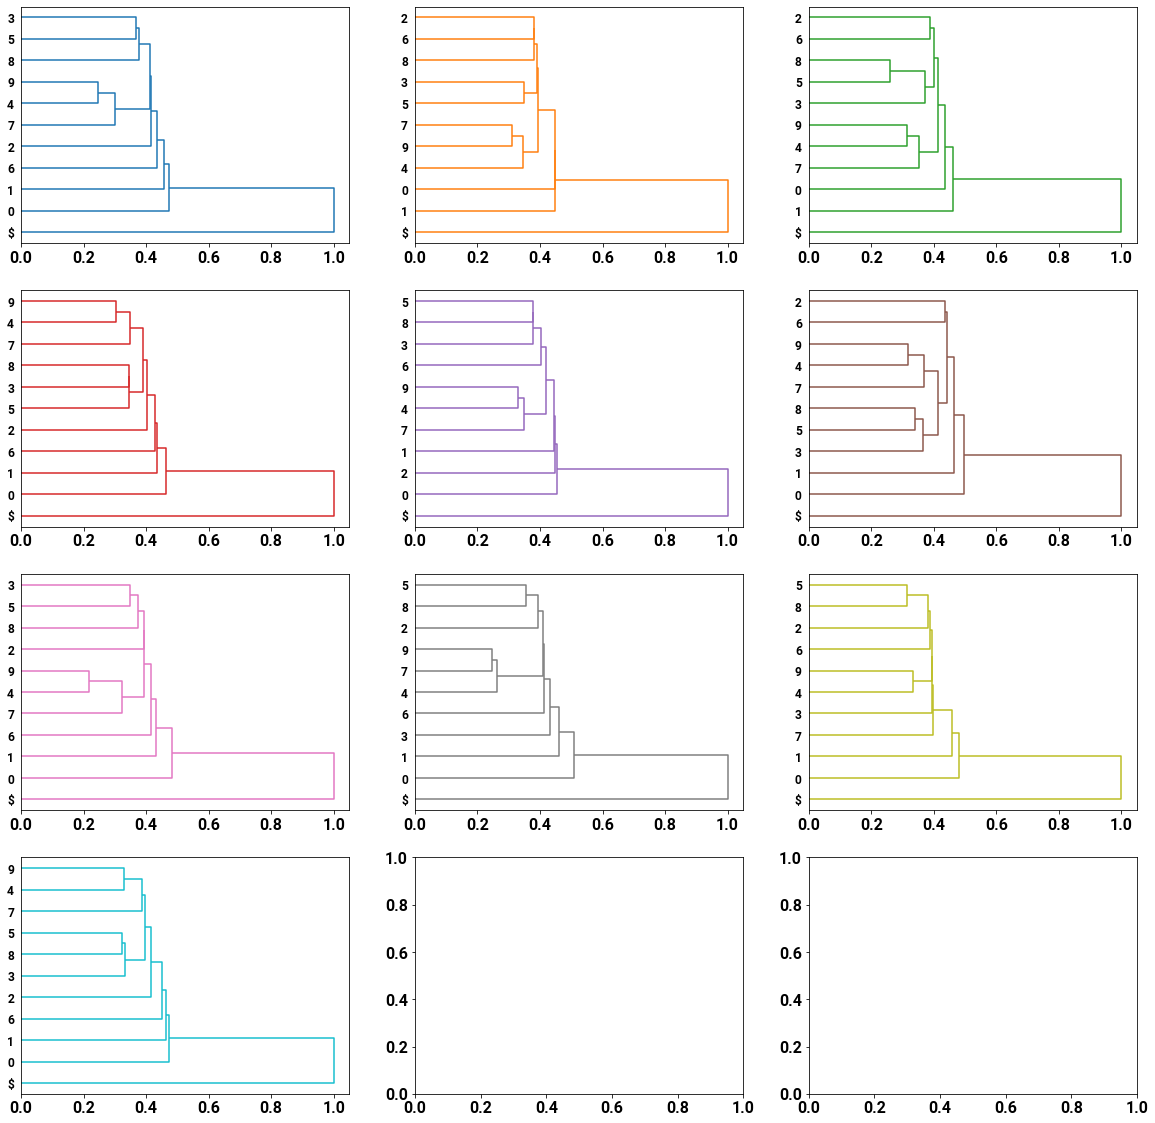

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
colors = [plt.cm.tab10(i) for i in range(10)]
for i, branch_defs in enumerate(all_branch_defs):
    linkage, cluster_id_to_leaf = branch_defs_to_linkage_matrix(branch_defs)
    scipy.cluster.hierarchy.dendrogram(
        linkage, ax=ax, orientation="right", color_threshold=0,
        link_color_func=(lambda _: plt.cm.colors.to_hex(plt.cm.tab10(i)))
    )
ax.set_yticklabels([])
plt.show()

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
for i, branch_defs in enumerate(all_branch_defs):
    linkage, cluster_id_to_leaf = branch_defs_to_linkage_matrix(branch_defs)
    row, col = i // 3, i % 3
    scipy.cluster.hierarchy.dendrogram(
        linkage, ax=ax[row][col], orientation="right", color_threshold=0,
        leaf_label_func=(lambda k: cluster_id_to_leaf[k]),
        link_color_func=(lambda _: plt.cm.colors.to_hex(plt.cm.tab10(i)))
    )
fig.savefig(
    os.path.join(out_path, "branch_diversity.svg"),
    format="svg"
)
plt.show()

### Generative performance between different variations

In [10]:
all_gen_samples = []
for i in range(num_trials):
    arr = np.load(os.path.join(cache_dir, "generated_digits", "trial_%d.npz" % i))
    gen_samples = {}
    for c in classes:
        gen_samples[c] = arr[str(c)]
    all_gen_samples.append(gen_samples)

In [11]:
# Sample true objects
true_samples = {}
for class_to_sample in classes:
    inds = np.where(dataset.targets == class_to_sample)[0]
    sample_inds = np.random.choice(inds, size=1000, replace=False)
    samples = ((dataset.data[sample_inds] / 256 * 2) - 1).cpu().numpy()[:, None]
    true_samples[class_to_sample] = samples

In [12]:
# Compute FIDs
all_fid_scores = []

for i in range(num_trials):
    print("Trial %d" % i)
    fid_scores = {}
    for class_to_sample in classes:
        fid_scores[class_to_sample] = compute_fid(
            true_samples[class_to_sample], all_gen_samples[i][class_to_sample]
        )
    all_fid_scores.append(fid_scores)

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


In [13]:
linear_fids = [
    105.5918, 49.4217, 111.4119, 87.9407, 47.4579, 72.9024, 70.4234, 56.0854, 85.4064, 58.2126
]

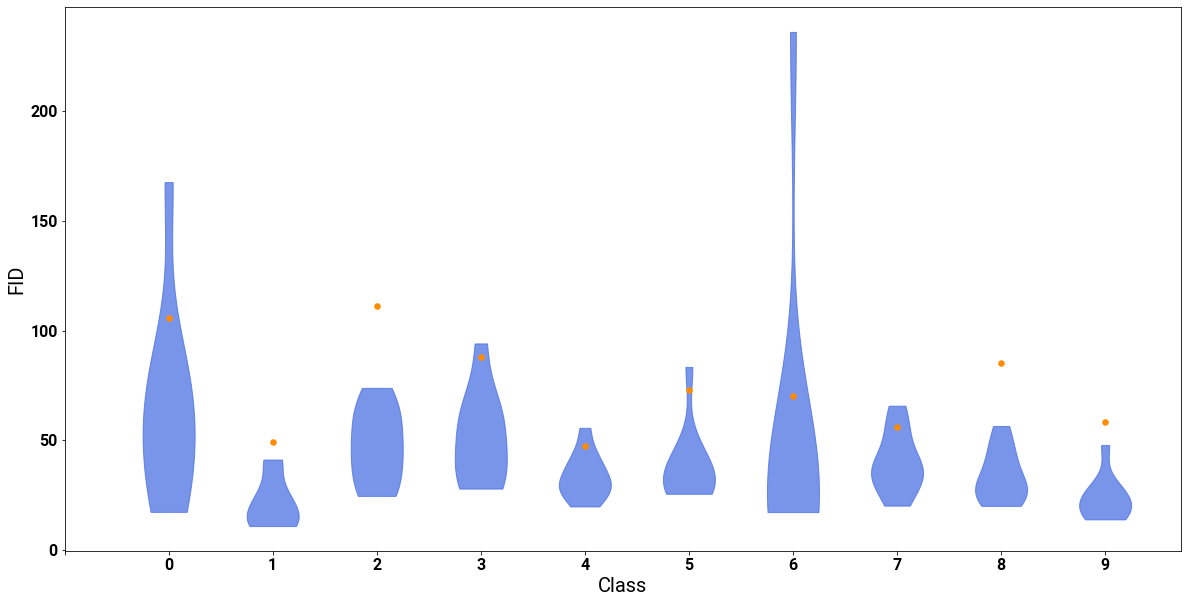

In [14]:
# Visualize FIDs between different variations
fig, ax = plt.subplots(figsize=(20, 10))

data = [[fid_scores[c] for fid_scores in all_fid_scores] for c in classes]
plot_parts = ax.violinplot(
    data, showmeans=False, showmedians=False, showextrema=False
)

violin_parts = plot_parts["bodies"]
for i, c in enumerate(classes):
    violin_parts[i].set_facecolor("royalblue")
    violin_parts[i].set_edgecolor("royalblue")
    violin_parts[i].set_alpha(0.7)

inds = np.arange(1, len(data) + 1)
ax.scatter(inds, linear_fids, marker="o", color="darkorange", s=30, zorder=2)
ax.set_ylabel("FID")
ax.set_xlabel("Class")
ax.set_xticks(np.arange(11))
ax.set_xticklabels([""] + [str(c) for c in classes])
fig.savefig(
    os.path.join(out_path, "fid_distributions.svg"),
    format="svg"
)
plt.show()

### Similarity between hierarchies

In [15]:
# Import tree distances
tree_out = os.path.join(cache_dir, "trees", "discovered_trees.out")
disc_dists = np.empty((num_trials, num_trials))
with open(tree_out, "r") as f:
    for line in f:
        if not line.startswith("Trees "):
            continue
        tokens = line.strip().split()
        i, j = int(tokens[1]) - 1, int(tokens[3][:-1]) - 1
        dist = float(tokens[4])
        disc_dists[i, j] = dist
        disc_dists[j, i] = dist

tree_out = os.path.join(cache_dir, "trees", "random_trees.out")
rand_dists = np.empty((num_trials, num_trials))
with open(tree_out, "r") as f:
    for line in f:
        if not line.startswith("Trees "):
            continue
        tokens = line.strip().split()
        i, j = int(tokens[1]) - 1, int(tokens[3][:-1]) - 1
        dist = float(tokens[4])
        rand_dists[i, j] = dist
        rand_dists[j, i] = dist

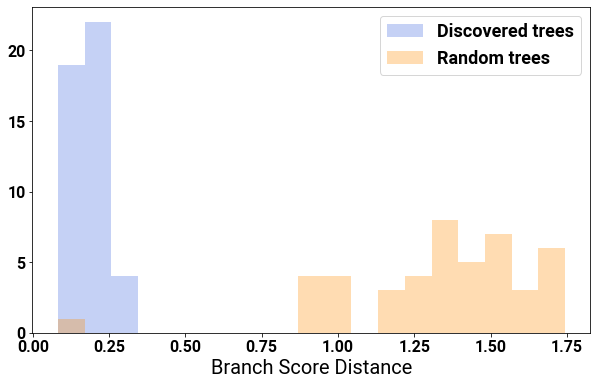

2.0679547538065143e-28


In [16]:
# Plot distances and compute significance
disc_vals = disc_dists[np.triu_indices(disc_dists.shape[0], k=1)]
rand_vals = rand_dists[np.triu_indices(rand_dists.shape[0], k=1)]
all_vals = np.concatenate([disc_vals, rand_vals])
bins = np.linspace(np.min(all_vals), np.max(all_vals), 20)
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(disc_vals, bins=bins, color="royalblue", alpha=0.3, label="Discovered trees")
ax.hist(rand_vals, bins=bins, color="darkorange", alpha=0.3, label="Random trees")
ax.set_xlabel("Branch Score Distance")
ax.legend()
fig.savefig(
    os.path.join(out_path, "branch_score_vs_random.svg"),
    format="svg"
)
plt.show()

p = scipy.stats.ttest_ind(
    disc_vals, rand_vals, equal_var=False, alternative="less"
)[1]
print(p)